<h1><center>Demo 2: Real-World Dataset</center></h1>

In this notebook we'll first be demoing the linear support vector machine implemented in the *base_estimators* library on the *Spam* dataset from Standford for binary classification We'll also demo the  one-vs-rest estimator in the *multiclass_estimators* library on the *Digits* dataset from scikit-learn for multiclassification.

In [10]:
import os
import sys

import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn import datasets
from matplotlib import pyplot as plt

sys.path.append("../libraries")
import example_utils as examp
import base_estimators as base
import multiclass_estimators as multi

plt.rcParams["figure.figsize"] = (14,8)

## Binary Classification Estimators

### Load and transform data for binary classification

In [3]:
url = "https://web.stanford.edu/~hastie/ElemStatLearn/datasets/spam.data"
cnames = ["col_"+str(x) for x in range(57)] + ["target"]
spam = pd.read_table(url, sep = "\s+", names = cnames)

In [4]:
X = spam.drop("target", 1).copy()
y = spam["target"].copy()

# Change target to -1/+1
y[y==0] = -1
# Divide the data into training and test sets. By default, 25% goes into the test set.
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

# Standardize the data
scaler = StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

### Fit linear support vector machine

Here we fit the model with default parameters (lambda = 1).

In [8]:
model = base.MyLinearSVM()
model.fit(X_train, y_train)

MyLinearSVM(eta_init=1, loss_function='squared-hinge', max_iter=100,
      reg_coef=1)

### Predict and check accuracy

In [56]:
train_preds = model.predict(X_train)
test_preds = model.predict(X_test)

print("Binary Classification training accuracy: {}".format(accuracy_score(y_train, train_preds)))
print("Binary Classification testing accuracy: {}".format(accuracy_score(y_test, test_preds)))

Binary Classification training accuracy: 0.9063768115942029
Binary Classification testing accuracy: 0.9122502172024327


### Tune linear support vector machine

The class is scikit-learn compatible and can be used with other scikit-learn classes like GridSearchCV. Here we tune the regularization parameter, lambda.

In [57]:
# Regularization coefficient
grid = {"reg_coef": [0.01, 0.1, 1, 2]}
modcv = GridSearchCV(base.MyLinearSVM(), param_grid=grid, cv=3)
modcv.fit(X_train, y_train)

GridSearchCV(cv=3, error_score='raise',
       estimator=MyLinearSVM(eta_init=1, loss_function='squared-hinge', max_iter=100,
      reg_coef=1),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'reg_coef': [0.01, 0.1, 1, 2]}, pre_dispatch='2*n_jobs',
       refit=True, return_train_score='warn', scoring=None, verbose=0)

In [58]:
train_preds = modcv.predict(X_train)
test_preds = modcv.predict(X_test)

print("Binary Classification training accuracy: {}".format(accuracy_score(y_train, train_preds)))
print("Binary Classification testing accuracy: {}".format(accuracy_score(y_test, test_preds)))

Binary Classification training accuracy: 0.9176811594202898
Binary Classification testing accuracy: 0.9131190269331017


### Visualize training results

Below is a plot showing the training and validation errors at different iterations during gradient descent. Notice that although the default number of iterations is 100, the problem converged (reached below the tolerance level of 1e-3) at around 25 iterations.

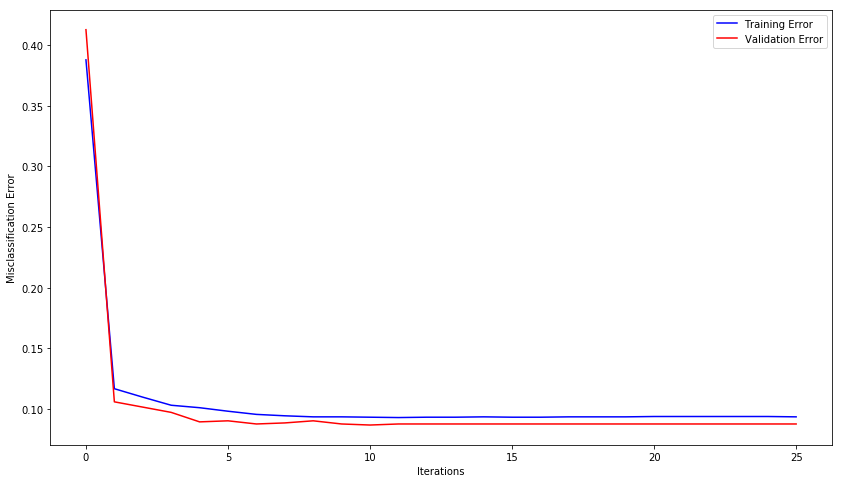

In [59]:
examp.plot_errors(model, X_train, y_train, X_test, y_test)

## Multiclassification Estimators

Now we demonstrate the *MyOneVsRestClassifier* implementation. It takes as arguments an instance of any scikit-learn compatible classifier (implements .fit, .predict, and .predict_proba).

It supports parallel computation of the labels by passing in an argument 'n_jobs'.

### Load and transform data for multi-class classification

In [41]:
X, y = datasets.load_digits(n_class=10, return_X_y=True)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

### Fit One-vs-Rest Multiclassifier with Linear SVMs

In [42]:
model = multi.MyOneVsRestClassifier(base.MyLinearSVM())
model.fit(X_train, y_train)

train_preds = model.predict(X_train)
test_preds = model.predict(X_test)

print("Multi-classification training accuracy: {}".format(accuracy_score(y_train, train_preds)))
print("Multi-classification testing accuracy: {}".format(accuracy_score(y_test, test_preds)))

Multi-classification training accuracy: 0.9651076466221232
Multi-classification testing accuracy: 0.9644444444444444


### Mutli-label Grid Search

The *MyOneVsRestClassifier* also allows passage of a grid parameter that will perform grid search for every label set. Note that if n_jobs is not equal to 1 the grid_n_jobs will automatically be forced to 1 regardless of the input. Below we demontstrate how to run the grid search in parallel.

In [43]:
# Performs grid search for every label
grid = {"reg_coef": [0.01, 0.1, 1]}
model = multi.MyOneVsRestClassifier(base.MyLinearSVM(), grid=grid, grid_n_jobs=-1)
model.fit(X_train, y_train)

train_preds = model.predict(X_train)
test_preds = model.predict(X_test)

print("Multi-classification training accuracy with grid search: {}".format(accuracy_score(y_train, train_preds)))
print("Multi-classification testing accuracy: {}".format(accuracy_score(y_test, test_preds)))

Multi-classification training accuracy with grid search: 0.9658500371195249
Multi-classification testing accuracy: 0.9666666666666667


In [46]:
best_lambdas = [mod.best_estimator_.reg_coef for mod in model.models_]

In [47]:
# Best parameters
best_lambdas

[1, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 1, 0.01]